In [2]:
#importing importatnt libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
#laoding dataset
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [4]:
len(dataset),len(test_dataset)

(50000, 10000)

In [5]:
#checking shape of each item of dataset
xb,yb=dataset[0]
xb.shape

torch.Size([3, 32, 32])

In [6]:
#total class labels in data
classes=dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Label(numeric): 6
label(text): frog


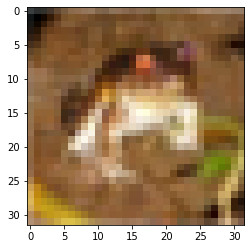

In [7]:
img,label=dataset[0]
plt.imshow(img.permute((1,2,0)))
print('Label(numeric):',label)
print('label(text):',classes[label])

In [8]:
#dividing training and validation sets
val_size=10000
train_size=len(dataset)-val_size
train,val=random_split(dataset,[train_size,val_size])
len(train),len(val)

(40000, 10000)

num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process

In [9]:
#laoding data in form of batches
batch_size=200
train_loader=DataLoader(train,batch_size,shuffle=True,num_workers=5,pin_memory=True)
val_loader=DataLoader(val,batch_size,num_workers=5,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size,num_workers=5,pin_memory=True)

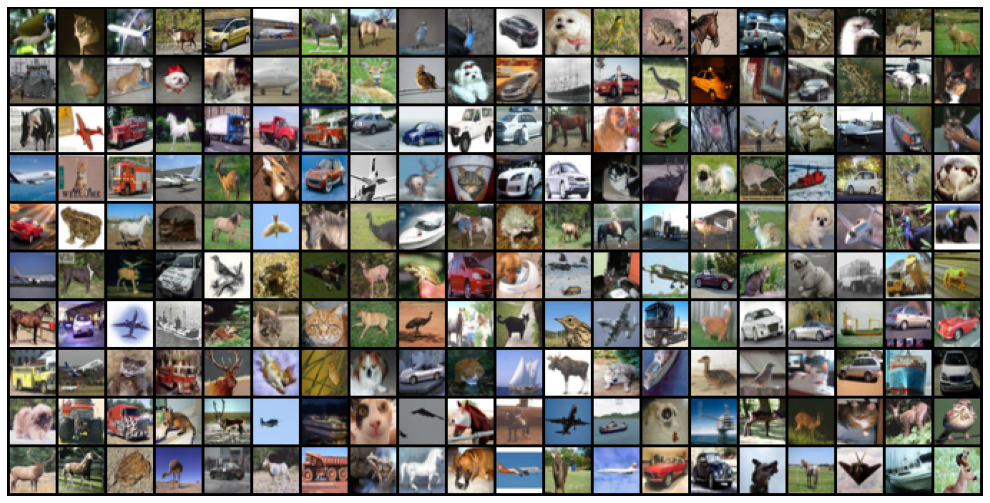

In [10]:
#Viewing 1 batch of data
for images,_ in train_loader:
    plt.figure(figsize=(18,9))
    plt.imshow(make_grid(images,nrow=20).permute((1,2,0)))
    plt.axis('off')
    break

In [11]:
#defining model
class NeuralModel(nn.Module):
    def __init__(self,in_size,out_size):
        super().__init__()
        self.linear1=nn.Linear(in_size,128)
        self.linear2=nn.Linear(128,256)
        self.linear3=nn.Linear(256,32)
        self.linear4=nn.Linear(32,out_size)
        
    def forward(self,xb):
        xb=xb.view(xb.size(0),-1)
        out=self.linear1(xb)
        out=F.relu(out)
        out=self.linear2(out)
        out=F.relu(out)
        out=self.linear3(out)
        out=F.relu(out)
        out=self.linear4(out)
        return out
    
    def training_step(self,batch):
        xb,yb=batch
        out=self(xb)
        loss=F.cross_entropy(out,yb)
        return loss
    
    def validation_step(self,batch):#it gives out accuracy and loss after 1 batch of validation set
        xb,yb=batch
        out=self(xb)
        loss=F.cross_entropy(out,yb)
        acc=accuracy(out,yb)
        return {'val_loss':loss.detach(),'val_acc':acc}
    
    def validation_end(self,outputs):#it gives out total accuracy and loss after all batches of validation set in on epooch
        batch_loss=[x['val_loss'] for x in outputs]#and then mean out all of them
        epoch_loss=torch.stack(batch_loss).mean() #combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("epoch[{}],val_loss:{:.4f},val_acc:{:.4f}".format(epoch,result['val_loss'],result['val_acc']))


In [12]:
#method to print accuracy
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [13]:
#checking whether gpu is present or not
torch.cuda.is_available()

True

In [14]:
def get_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device=get_device()
device

device(type='cuda')

In [16]:
#This fnc moves all model values and data to gpu device
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
    

In [ ]:
'''for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break'''

> Finally, we define a **DeviceLoader** class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

In [17]:
#defining class which moves all batches of data to gpu
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
#moving train_loader and val_loader in device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [19]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([8, 9, 5, 7, 5, 3, 9, 9, 4, 8, 3, 8, 1, 6, 2, 0, 1, 8, 0, 7, 0, 6, 4, 6,
        7, 3, 0, 8, 7, 0, 8, 5, 7, 0, 5, 8, 4, 1, 0, 0, 1, 4, 1, 6, 3, 5, 8, 2,
        1, 1, 2, 6, 9, 7, 9, 1, 5, 8, 1, 8, 8, 7, 2, 1, 6, 0, 2, 4, 7, 8, 0, 7,
        3, 6, 1, 2, 5, 1, 9, 9, 9, 4, 9, 6, 8, 7, 8, 2, 1, 4, 2, 4, 0, 8, 8, 2,
        2, 9, 9, 6, 5, 7, 8, 6, 8, 4, 2, 3, 5, 9, 7, 2, 0, 8, 9, 2, 1, 6, 4, 4,
        0, 7, 4, 4, 2, 1, 9, 6, 4, 7, 5, 2, 1, 7, 3, 7, 3, 2, 4, 3, 0, 8, 6, 4,
        6, 1, 9, 1, 9, 2, 2, 8, 4, 1, 4, 4, 3, 0, 3, 3, 8, 7, 7, 6, 5, 6, 1, 7,
        9, 6, 6, 5, 9, 5, 5, 1, 3, 3, 2, 5, 3, 2, 1, 1, 0, 5, 3, 7, 0, 4, 4, 3,
        7, 6, 5, 1, 5, 1, 3, 3], device='cuda:0')


In [20]:
def evaluate(model,val_loader):
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_end(outputs)

def fit(epochs,model,lr,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]#it is used to store the result of the model
    optimizer=opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result=evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [21]:
# Moving Model (on GPU)
in_size=3*32*32
out_size=10
model = NeuralModel(in_size,out_size)
to_device(model,device)

NeuralModel(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=10, bias=True)
)

In [22]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.308436632156372, 'val_acc': 0.09850000590085983}]

[{'val_loss': 2.308436632156372, 'val_acc': 0.09850000590085983}]

In [23]:
history+=fit(10,model,0.1,train_loader,val_loader)

epoch[0],val_loss:2.0621,val_acc:0.2228
epoch[1],val_loss:1.9219,val_acc:0.3078
epoch[2],val_loss:1.7759,val_acc:0.3520
epoch[3],val_loss:1.7367,val_acc:0.3699
epoch[4],val_loss:1.7366,val_acc:0.3711
epoch[5],val_loss:1.7405,val_acc:0.3728
epoch[6],val_loss:1.6658,val_acc:0.4142
epoch[7],val_loss:1.6773,val_acc:0.4044
epoch[8],val_loss:1.6088,val_acc:0.4256
epoch[9],val_loss:1.5486,val_acc:0.4471


1. epoch[0],val_loss:2.0621,val_acc:0.2228
2. epoch[1],val_loss:1.9219,val_acc:0.3078
3. epoch[2],val_loss:1.7759,val_acc:0.3520
4. epoch[3],val_loss:1.7367,val_acc:0.3699
5. epoch[4],val_loss:1.7366,val_acc:0.3711
6. epoch[5],val_loss:1.7405,val_acc:0.3728
7. epoch[6],val_loss:1.6658,val_acc:0.4142
8. epoch[7],val_loss:1.6773,val_acc:0.4044
9. epoch[8],val_loss:1.6088,val_acc:0.4256
10. epoch[9],val_loss:1.5486,val_acc:0.4471

In [24]:
history+=fit(10,model,0.1,train_loader,val_loader)

epoch[0],val_loss:1.6699,val_acc:0.4116
epoch[1],val_loss:1.5504,val_acc:0.4370
epoch[2],val_loss:1.5614,val_acc:0.4397
epoch[3],val_loss:1.5776,val_acc:0.4294
epoch[4],val_loss:1.5022,val_acc:0.4679
epoch[5],val_loss:1.5000,val_acc:0.4528
epoch[6],val_loss:1.4939,val_acc:0.4620
epoch[7],val_loss:1.4624,val_acc:0.4824
epoch[8],val_loss:1.6372,val_acc:0.4226
epoch[9],val_loss:1.4782,val_acc:0.4705


In [25]:
history+=fit(10,model,0.01,train_loader,val_loader)

epoch[0],val_loss:1.3853,val_acc:0.5104
epoch[1],val_loss:1.3824,val_acc:0.5115
epoch[2],val_loss:1.3797,val_acc:0.5149
epoch[3],val_loss:1.3764,val_acc:0.5122
epoch[4],val_loss:1.3787,val_acc:0.5125
epoch[5],val_loss:1.3764,val_acc:0.5142
epoch[6],val_loss:1.3730,val_acc:0.5153
epoch[7],val_loss:1.3724,val_acc:0.5142
epoch[8],val_loss:1.3688,val_acc:0.5169
epoch[9],val_loss:1.3696,val_acc:0.5166


In [26]:
history+=fit(10,model,0.01,train_loader,val_loader)

epoch[0],val_loss:1.3662,val_acc:0.5210
epoch[1],val_loss:1.3683,val_acc:0.5164
epoch[2],val_loss:1.3648,val_acc:0.5190
epoch[3],val_loss:1.3623,val_acc:0.5187
epoch[4],val_loss:1.3607,val_acc:0.5237
epoch[5],val_loss:1.3616,val_acc:0.5192
epoch[6],val_loss:1.3603,val_acc:0.5204
epoch[7],val_loss:1.3605,val_acc:0.5243
epoch[8],val_loss:1.3568,val_acc:0.5201
epoch[9],val_loss:1.3555,val_acc:0.5251


epoch[0],val_loss:1.3662,val_acc:0.5210

epoch[1],val_loss:1.3683,val_acc:0.5164

epoch[2],val_loss:1.3648,val_acc:0.5190

epoch[3],val_loss:1.3623,val_acc:0.5187

epoch[4],val_loss:1.3607,val_acc:0.5237

epoch[5],val_loss:1.3616,val_acc:0.5192

epoch[6],val_loss:1.3603,val_acc:0.5204

epoch[7],val_loss:1.3605,val_acc:0.5243

epoch[8],val_loss:1.3568,val_acc:0.5201

epoch[9],val_loss:1.3555,val_acc:0.5251

In [29]:
#checking model on testdata
test_loader=DeviceDataLoader(test_loader,device)
evaluate(model,test_loader)

{'val_loss': 1.3515828847885132, 'val_acc': 0.5239999890327454}

{'val_loss': 1.3515828847885132, 'val_acc': 0.5239999890327454}

Text(0.5, 1.0, 'Loss vs No of epochs')

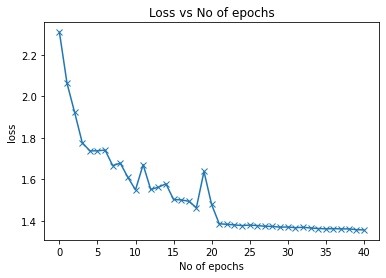

In [30]:
loss=[x['val_loss'] for x in history]
plt.plot(loss,'-x')
plt.xlabel('No of epochs')
plt.ylabel('loss')
plt.title('Loss vs No of epochs')

Text(0.5, 1.0, 'Accuracy vs No of epochs')

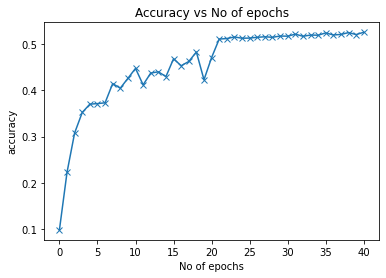

In [31]:
accu=[x['val_acc'] for x in history]
plt.plot(accu,'-x')
plt.xlabel('No of epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')